In [1]:
import pandas as pd 

In [2]:
import numpy as np 

In [3]:
from PIL import Image

In [4]:
from matplotlib import pyplot as plt

In [5]:
from tqdm.notebook import tqdm

In [6]:
from nltk.translate.bleu_score import corpus_bleu

In [7]:
import pickle 

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [9]:
from tensorflow.keras.models import Model, load_model

In [10]:
import os

In [11]:
import numpy as np

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [13]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [15]:
from tensorflow.keras.utils import to_categorical, plot_model 

In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
BASE_DIR = 'Dataset/'
WORKING_DIR = './'

In [4]:
model = VGG16()

In [ ]:
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [5]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
features = {} 
directory = os.path.join(BASE_DIR, 'Images') 

In [6]:
for img_name in tqdm(os.listdir(directory)):
    img_path = directory + "/" + img_name 
    image = load_img(img_path, target_size=(224, 224)) 
    image = img_to_array(image) 
    
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) 
    image = preprocess_input(image) 
    
    img_feature = model.predict(image, verbose=0)
    
    image_id = img_name.split('.')[0] 
    
    features[image_id] = img_feature 


  0%|          | 0/8091 [00:00<?, ?it/s]

In [7]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [8]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [9]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [20]:
print(captions_doc)

NameError: name 'captions_doc' is not defined

In [19]:
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2: 
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0] 
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

NameError: name 'captions_doc' is not defined

In [12]:
len(mapping)

8091

In [13]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower() 
            caption = caption.replace('[^A-Za-z]', '') 
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption # re-assigning
            

In [14]:
mapping['1000268201_693b08cb0e'] 

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [15]:
clean(mapping)

In [16]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [17]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [18]:
len(all_captions)

40455

In [19]:
all_captions[:10] #first 10 captions

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [21]:
vocab_size

8485

In [22]:
max_length = max( len(caption.split()) for caption in all_captions )
max_length

35

In [23]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90) # 90% data to be train
print("Data to be train:", split)
print("Data to be test:", len(mapping)-split)

train = image_ids[:split]
test = image_ids[split:]

print(len(test))

Data to be train: 7281
Data to be test: 810
810


In [25]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    
    while 1:
        for key in data_keys:
            n = n+1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i] 
                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
  
                    X1.append(features[key][0]) 
                    X2.append(in_seq) 
                    y.append(out_seq) 
            
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0
                    

In [ ]:
def create_model():
    inputs1 = Input(shape=(4096,)) 
    fe1 = Dropout(0.4)(inputs1) 
    fe2 = Dense(256, activation = 'relu')(fe1) 

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2) 
    se2 = Dropout(0.4)(se1)
    se3 = LSTM(256)(se2)
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2) 
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
model = create_model()

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
epochs = 20 
batch_size = 32
steps = len(train)//batch_size 

In [27]:
for i in range(epochs): 
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 265s 1s/step - loss: 2.2106


In [28]:
model.save('best_model.h5')

In [29]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [30]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0) 
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
        
    return in_text 

In [31]:
actual, predicted = list(), list()

for key in tqdm(test):

    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    
    actual_captions = [caption.split() for caption in captions] #split into words
    actual.append(actual_captions)
    
    y_pred = y_pred.split() 
    predicted.append(y_pred)
    
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))) # one gram
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))) # two-gram

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.528515
BLEU-2: 0.306071


In [33]:
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    image_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(image_path)
    captions = mapping[image_id]

    print('-------------------------Actual--------------------------------')

    for caption in captions:
        print(caption)

    print('-------------------------Predicted--------------------------------')

    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print(y_pred)

    plt.imshow(image)

-------------------------Actual--------------------------------
startseq man in an orange hat starring at something endseq
startseq man wears an orange hat and glasses endseq
startseq man with gauges and glasses is wearing blitz hat endseq
startseq man with glasses is wearing beer can crocheted hat endseq
startseq the man with pierced ears is wearing glasses and an orange hat endseq
-------------------------Predicted--------------------------------
startseq man wearing red hat and hat smiles endseq


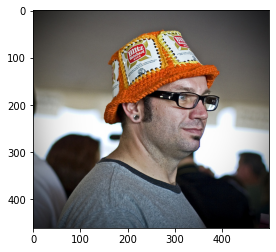

In [35]:
image_name = "95734036_bef6d1a871.jpg" 

generate_caption(image_name)